In [ ]:
!nvidia-smi

Fri Dec 16 11:20:42 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P0    30W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!git clone https://gitlab.com/juan.ardiles/Cifar10/

Cloning into 'Cifar10'...
remote: Enumerating objects: 69, done.
remote: Counting objects: 100% (51/51), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 69 (delta 15), reused 0 (delta 0), pack-reused 18
Unpacking objects: 100% (69/69), done.
Checking out files: 100% (23/23), done.


# Knowledge Distillation

In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers as L
import time
from random import seed
from random import randint

# Data Preparation

In [ ]:
(x_train, y_train), (x_valid, y_valid) = keras.datasets.cifar10.load_data()
x_train = x_train/255.0
x_valid = x_valid/255.0
# x_train = np.expand_dims(x_train, axis=3)
# x_valid = np.expand_dims(x_valid, axis=3)
y_train = keras.utils.to_categorical(y_train)
y_valid = keras.utils.to_categorical(y_valid)

170498071/170498071 [==============================] - 14s 0us/step


In [ ]:
T_EPOCHS = 50
S_EPOCHS = 20
IMAGE_SIZE = x_train.shape[1:]
BATCH_SIZE = 512
N_CLASSES = y_train.shape[-1]
IMAGE_SIZE, N_CLASSES

((32, 32, 3), 10)

In [ ]:
def nn_callbacks():
    es = keras.callbacks.EarlyStopping(
        patience=5, verbose=1, restore_best_weights=True, min_delta=1e-4
    )
    rlp = keras.callbacks.ReduceLROnPlateau(patience=2, verbose=1)
    return [es, rlp]

In [ ]:
d_train = tf.data.Dataset.from_tensor_slices((x_train, y_train))
d_valid = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))

del x_train, x_valid, y_train, y_valid

# Building the Models

**Teacher Model**

In [ ]:
def build_teacher_model(name='teacher'):
    base_model = keras.applications.VGG19(input_shape=IMAGE_SIZE, include_top=False)
    base_model.trainable = True
    return keras.models.Sequential([
            base_model,        
            L.GlobalAvgPool2D(),        
            L.Dense(N_CLASSES)
        ], name=name
    )
        

teacher_model = build_teacher_model()
teacher_model.summary()


80134624/80134624 [==============================] - 5s 0us/step
Model: "teacher"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 10)                5130      
                                                                 
Total params: 20,029,514
Trainable params: 20,029,514
Non-trainable params: 0
_________________________________________________________________


**Student Model**

In [ ]:
def build_student_model(name='student'):
    return keras.models.Sequential([
        L.Conv2D(64, 3, input_shape=IMAGE_SIZE, padding='same', activation='relu'),
        L.Conv2D(64, 3, padding='same', activation='relu'),
        L.Conv2D(64, 3, padding='same', activation='relu'),
        L.MaxPool2D(pool_size=2),
        L.Conv2D(64, 3, padding='same', activation='relu'),
        L.Conv2D(64, 3, padding='same', activation='relu'),
        L.Conv2D(64, 3, padding='same', activation='relu'),
        L.MaxPool2D(pool_size=2),
        L.Conv2D(64, 3, padding='same', activation='relu'),
        L.Conv2D(64, 3, padding='same', activation='relu'),
        L.Conv2D(64, 3, padding='same', activation='relu'),
        L.MaxPool2D(pool_size=2),
        L.Conv2D(64, 3, padding='same', activation='relu'),
        L.Conv2D(64, 3, padding='same', activation='relu'),
        L.Conv2D(64, 3, padding='same', activation='relu'),
        L.MaxPool2D(pool_size=2),
        L.Conv2D(64, 3, padding='same', activation='relu'),
        L.Conv2D(64, 3, padding='same', activation='relu'),
        L.Conv2D(64, 3, padding='same', activation='relu'),
        L.MaxPool2D(pool_size=2),
        L.GlobalAvgPool2D(),
        L.Dense(N_CLASSES),
    ],name=name) 

student_model = build_student_model()
student2_model = build_student_model()
student4_model = build_student_model()
student_model.summary()

Model: "student"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 64)       0         
 )                                                               
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 64)        36928     
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 16, 64)        36928     
                                                           

# Traning student without KD

In [ ]:
student_solito = build_student_model()
student_solito.compile(
      optimizer=keras.optimizers.Adam(1e-5), 
      loss=keras.losses.CategoricalCrossentropy(from_logits=True),
      metrics=['accuracy']
  )
history = student_solito.fit(
      d_train.shuffle(1024, 19).batch(BATCH_SIZE),
      validation_data=d_valid.shuffle(1024, 19).batch(BATCH_SIZE),
      epochs=T_EPOCHS,
      callbacks=nn_callbacks(), 
      batch_size=BATCH_SIZE
  )
student_solito.save('student_solito.h5')
np.save('solito.npy',history.history)

Epoch 1/50
98/98 [==============================] - 23s 125ms/step - loss: 2.3023 - accuracy: 0.1002 - val_loss: 2.3012 - val_accuracy: 0.1000 - lr: 1.0000e-05
Epoch 2/50
98/98 [==============================] - 11s 112ms/step - loss: 2.2858 - accuracy: 0.1000 - val_loss: 2.2435 - val_accuracy: 0.1000 - lr: 1.0000e-05
Epoch 3/50
98/98 [==============================] - 11s 113ms/step - loss: 2.1882 - accuracy: 0.1362 - val_loss: 2.1488 - val_accuracy: 0.1875 - lr: 1.0000e-05
Epoch 4/50
98/98 [==============================] - 11s 113ms/step - loss: 2.1085 - accuracy: 0.2107 - val_loss: 2.0440 - val_accuracy: 0.2552 - lr: 1.0000e-05
Epoch 5/50
98/98 [==============================] - 11s 113ms/step - loss: 2.0024 - accuracy: 0.2680 - val_loss: 1.9653 - val_accuracy: 0.2828 - lr: 1.0000e-05
Epoch 6/50
98/98 [==============================] - 11s 113ms/step - loss: 1.9491 - accuracy: 0.2840 - val_loss: 1.9258 - val_accuracy: 0.2983 - lr: 1.0000e-05
Epoch 7/50
98/98 [======================

In [ ]:
import os
print('Student Model:')
student_solito.evaluate(d_valid.shuffle(1024, 19).batch(BATCH_SIZE))
print("File Size is :", round(os.path.getsize('student_solito.h5')/1024**2, 2), "MB")

Student Model:
20/20 [==============================] - 1s 47ms/step - loss: 1.5096 - accuracy: 0.4355
File Size is : 6.09 MB


# Training Teacher

In [ ]:
Entrenar = False
if (Entrenar):
  teacher_model.compile(
      optimizer=keras.optimizers.Adam(1e-5), 
      loss=keras.losses.CategoricalCrossentropy(from_logits=True),
      metrics=['accuracy']
  )

  history = teacher_model.fit(
      d_train.shuffle(1024, 19).batch(BATCH_SIZE),
      validation_data=d_valid.shuffle(1024, 19).batch(BATCH_SIZE),
      epochs=T_EPOCHS,
      callbacks=nn_callbacks(), 
      batch_size=BATCH_SIZE
  )

  teacher_model.save('teacher1.h5')


# Load Save Models

In [ ]:
teacher1 = tf.keras.models.load_model('Cifar10/teacher1.h5')
teacher2 = tf.keras.models.load_model('Cifar10/teacher2.h5')
teacher3 = tf.keras.models.load_model('Cifar10/teacher3.h5')
teacher4 = tf.keras.models.load_model('Cifar10/teacher4.h5')
teacher5 = tf.keras.models.load_model('Cifar10/teacher5.h5')

student5_model = tf.keras.models.load_model('Cifar10/student5.h5')

# Before Distill

In [ ]:


distiller_Comp = False
distiller2_Comp = False
distiller5_Comp = False
distiller5R_Comp = False

# Distillation in Action

In [ ]:
class Distiller(keras.Model):
    def __init__(self, student, teacher, activation):
        super().__init__()
        self.teacher = teacher
        self.student = student
        self.activation = activation

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.1,
        temperature=10,
    ):
        super().compile(optimizer=optimizer, metrics=metrics)
        self.student.compile(optimizer=optimizer, metrics=metrics, loss=student_loss_fn)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        x, y = data
        teacher_predictions = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
            student_predictions = self.student(x, training=True)
            student_loss = self.student_loss_fn(y, student_predictions)
            distillation_loss = self.distillation_loss_fn(
                self.activation(teacher_predictions / self.temperature, axis=1),
                self.activation(student_predictions / self.temperature, axis=1),
            )
            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        self.compiled_metrics.update_state(y, student_predictions)

        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss, "loss": loss}
        )
        return results

    def test_step(self, data):
        x, y = data
        teacher_predictions = self.teacher(x, training=False)
        student_predictions = self.student(x, training=False)
        
        student_loss = self.student_loss_fn(y, student_predictions)
        distillation_loss = self.distillation_loss_fn(
            self.activation(teacher_predictions / self.temperature, axis=1),
            self.activation(student_predictions / self.temperature, axis=1),
        )
        loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss
        
        self.compiled_metrics.update_state(y, student_predictions)

        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss, "loss": loss}
        )
        return results
    
    def call(self, x):
        return self.student(x)

In [ ]:
distiller = Distiller(student_model, teacher1, tf.nn.softmax)
distiller.compile(
    optimizer=keras.optimizers.Adam(),
    metrics=['accuracy'],
    student_loss_fn=keras.losses.CategoricalCrossentropy(from_logits=True),
    distillation_loss_fn=keras.losses.KLDivergence(),
    alpha=0.7,
    temperature=100,
)
history1 = distiller.fit(
    d_train.shuffle(1024, 19).batch(BATCH_SIZE), 
    validation_data=d_valid.shuffle(1024, 19).batch(BATCH_SIZE),
    epochs=S_EPOCHS, callbacks=nn_callbacks(), batch_size=BATCH_SIZE
)
np.save('history1.npy',history1.history)
distiller_Comp = True

Epoch 1/20
98/98 [==============================] - 34s 227ms/step - accuracy: 0.2345 - student_loss: 2.0426 - distillation_loss: 0.0011 - loss: 1.4302 - val_accuracy: 0.3157 - val_student_loss: 1.8036 - val_distillation_loss: 9.0797e-04 - val_loss: 1.2628 - lr: 0.0010
Epoch 2/20
98/98 [==============================] - 19s 191ms/step - accuracy: 0.3504 - student_loss: 1.7150 - distillation_loss: 8.2866e-04 - loss: 1.2008 - val_accuracy: 0.4017 - val_student_loss: 1.5470 - val_distillation_loss: 6.8145e-04 - val_loss: 1.0831 - lr: 0.0010
Epoch 3/20
98/98 [==============================] - 19s 192ms/step - accuracy: 0.4350 - student_loss: 1.5002 - distillation_loss: 7.1361e-04 - loss: 1.0504 - val_accuracy: 0.4872 - val_student_loss: 1.4259 - val_distillation_loss: 6.6032e-04 - val_loss: 0.9983 - lr: 0.0010
Epoch 4/20
98/98 [==============================] - 19s 189ms/step - accuracy: 0.5182 - student_loss: 1.3004 - distillation_loss: 6.1974e-04 - loss: 0.9104 - val_accuracy: 0.5545 - v

# Distillation with 2 teachers


In [ ]:
class Distiller2(keras.Model):
    def __init__(self, student, teacher1, teacher2,activation):
        super().__init__()
        self.teacher1 = teacher1
        self.teacher2 = teacher2
        self.student = student
        self.activation = activation

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.1,
        temperature=10,
    ):
        """ Configure the distiller.

        Args:
            optimizer: Keras optimizer for the student weights
            metrics: Keras metrics for evaluation
            student_loss_fn: Loss function of difference between student
                predictions and ground-truth
            distillation_loss_fn: Loss function of difference between soft
                student predictions and soft teacher predictions
            alpha: weight to student_loss_fn and 1-alpha to distillation_loss_fn
            temperature: Temperature for softening probability distributions.
                Larger temperature gives softer distributions.
        """
        super().compile(optimizer=optimizer, metrics=metrics)
        self.student.compile(optimizer=optimizer, metrics=metrics, loss=student_loss_fn)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        x, y = data
        teacher_predictions = self.teacher1(x, training=False)
        teacher2_predictions = self.teacher2(x, training=False)


        teacher_promedio = teacher_predictions*0.5 + teacher2_predictions*0.5

        with tf.GradientTape() as tape:
            student_predictions = self.student(x, training=True)
            student_loss = self.student_loss_fn(y, student_predictions)
            distillation_loss = self.distillation_loss_fn(
                self.activation(teacher_promedio / self.temperature, axis=1),
                self.activation(student_predictions / self.temperature, axis=1),
            )
            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        self.compiled_metrics.update_state(y, student_predictions)

        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss, "loss": loss}
        )
        return results

    def test_step(self, data):
        x, y = data
        teacher_predictions = self.teacher1(x, training=False)
        teacher2_predictions = self.teacher2(x, training=False)

        student_predictions = self.student(x, training=False)
        
        teacher_promedio = teacher_predictions*0.5 + teacher2_predictions*0.5
        student_loss = self.student_loss_fn(y, student_predictions)
        distillation_loss = self.distillation_loss_fn(
            self.activation(teacher_promedio / self.temperature, axis=1),
            self.activation(student_predictions / self.temperature, axis=1),
        )
        loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss
        
        self.compiled_metrics.update_state(y, student_predictions)

        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss, "loss": loss}
        )
        return results
    
    def call(self, x):
        return self.student(x)

In [ ]:
student2_model = build_student_model()
distiller2 = Distiller2(student2_model, teacher1, teacher2, tf.nn.softmax)
distiller2.compile(
    optimizer=keras.optimizers.Adam(),
    metrics=['accuracy'],
    student_loss_fn=keras.losses.CategoricalCrossentropy(from_logits=True),
    distillation_loss_fn=keras.losses.KLDivergence(),
    alpha=0.7,
    temperature=100,
)
history2 = distiller2.fit(
    d_train.shuffle(1024, 19).batch(BATCH_SIZE), 
    validation_data=d_valid.shuffle(1024, 19).batch(BATCH_SIZE),
    epochs=S_EPOCHS, callbacks=nn_callbacks(), batch_size=BATCH_SIZE
)
distiller2_Comp = True
np.save('history2.npy',history2.history)

Epoch 1/20
98/98 [==============================] - 29s 278ms/step - accuracy: 0.1821 - student_loss: 2.1643 - distillation_loss: 0.0011 - loss: 1.5153 - val_accuracy: 0.3053 - val_student_loss: 1.9202 - val_distillation_loss: 8.9998e-04 - val_loss: 1.3444 - lr: 0.0010
Epoch 2/20
98/98 [==============================] - 27s 271ms/step - accuracy: 0.3467 - student_loss: 1.7354 - distillation_loss: 8.1799e-04 - loss: 1.2150 - val_accuracy: 0.3565 - val_student_loss: 1.6179 - val_distillation_loss: 6.9682e-04 - val_loss: 1.1327 - lr: 0.0010
Epoch 3/20
98/98 [==============================] - 26s 267ms/step - accuracy: 0.4364 - student_loss: 1.5172 - distillation_loss: 6.9954e-04 - loss: 1.0623 - val_accuracy: 0.4864 - val_student_loss: 1.4280 - val_distillation_loss: 6.4948e-04 - val_loss: 0.9998 - lr: 0.0010
Epoch 4/20
98/98 [==============================] - 27s 274ms/step - accuracy: 0.5074 - student_loss: 1.3389 - distillation_loss: 6.0779e-04 - loss: 0.9374 - val_accuracy: 0.5217 - v

# Distiller with 5 teachers

In [ ]:
class Distiller5(keras.Model):
    def __init__(self, student, teacher1, teacher2,teacher3,teacher4,teacher5,activation):
        super().__init__()
        self.teacher = teacher1
        self.teacher2 = teacher2
        self.teacher3 = teacher3
        self.teacher4 = teacher4
        self.teacher5 = teacher5
        self.student = student
        self.activation = activation

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.1,
        temperature=10,
    ):
        """ Configure the distiller.

        Args:
            optimizer: Keras optimizer for the student weights
            metrics: Keras metrics for evaluation
            student_loss_fn: Loss function of difference between student
                predictions and ground-truth
            distillation_loss_fn: Loss function of difference between soft
                student predictions and soft teacher predictions
            alpha: weight to student_loss_fn and 1-alpha to distillation_loss_fn
            temperature: Temperature for softening probability distributions.
                Larger temperature gives softer distributions.
        """
        super().compile(optimizer=optimizer, metrics=metrics)
        self.student.compile(optimizer=optimizer, metrics=metrics, loss=student_loss_fn)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        x, y = data
        teacher_predictions = self.teacher(x, training=False)
        teacher2_predictions = self.teacher2(x, training=False)
        teacher3_predictions = self.teacher3(x, training=False)
        teacher4_predictions = self.teacher4(x, training=False)
        teacher5_predictions = self.teacher5(x, training=False)


        teacher_promedio = teacher_predictions*0.2 + teacher2_predictions*0.2 + teacher3_predictions*0.2 + teacher4_predictions*0.2 + teacher5_predictions * 0.2

        with tf.GradientTape() as tape:
            student_predictions = self.student(x, training=True)
            student_loss = self.student_loss_fn(y, student_predictions)
            distillation_loss = self.distillation_loss_fn(
                self.activation(teacher_promedio / self.temperature, axis=1),
                self.activation(student_predictions / self.temperature, axis=1),
            )
            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        self.compiled_metrics.update_state(y, student_predictions)

        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss, "loss": loss}
        )
        return results

    def test_step(self, data):
        x, y = data

        student_predictions = self.student(x, training=False)
        
        teacher_predictions = self.teacher(x, training=False)
        teacher2_predictions = self.teacher2(x, training=False)
        teacher3_predictions = self.teacher3(x, training=False)
        teacher4_predictions = self.teacher4(x, training=False)
        teacher5_predictions = self.teacher5(x, training=False)


        teacher_promedio = teacher_predictions*0.2 + teacher2_predictions*0.2 + teacher3_predictions*0.2 + teacher4_predictions*0.2 + teacher5_predictions * 0.2
        student_loss = self.student_loss_fn(y, student_predictions)
        distillation_loss = self.distillation_loss_fn(
            self.activation(teacher_promedio / self.temperature, axis=1),
            self.activation(student_predictions / self.temperature, axis=1),
        )
        loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss
        
        self.compiled_metrics.update_state(y, student_predictions)

        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss, "loss": loss}
        )
        return results
    
    def call(self, x):
        return self.student(x)

In [ ]:
student5_model = build_student_model()
distiller5 = Distiller5(student5_model, teacher1, teacher2,teacher3,teacher4,teacher5, tf.nn.softmax)
distiller5.compile(
    optimizer=keras.optimizers.Adam(),
    metrics=['accuracy'],
    student_loss_fn=keras.losses.CategoricalCrossentropy(from_logits=True),
    distillation_loss_fn=keras.losses.KLDivergence(),
    alpha=0.7,
    temperature=100,
)
history5 = distiller5.fit(
    d_train.shuffle(1024, 19).batch(BATCH_SIZE), 
    validation_data=d_valid.shuffle(1024, 19).batch(BATCH_SIZE),
    epochs=S_EPOCHS, callbacks=nn_callbacks(), batch_size=BATCH_SIZE
)
distiller5_Comp = True
np.save('history5.npy',history5.history)

Epoch 1/20
98/98 [==============================] - 54s 527ms/step - accuracy: 0.1834 - student_loss: 2.1721 - distillation_loss: 0.0011 - loss: 1.5208 - val_accuracy: 0.3034 - val_student_loss: 1.8564 - val_distillation_loss: 8.4358e-04 - val_loss: 1.2998 - lr: 0.0010
Epoch 2/20
98/98 [==============================] - 50s 510ms/step - accuracy: 0.3360 - student_loss: 1.7537 - distillation_loss: 7.7297e-04 - loss: 1.2278 - val_accuracy: 0.4071 - val_student_loss: 1.5565 - val_distillation_loss: 6.1088e-04 - val_loss: 1.0897 - lr: 0.0010
Epoch 3/20
98/98 [==============================] - 49s 503ms/step - accuracy: 0.4174 - student_loss: 1.5508 - distillation_loss: 6.5854e-04 - loss: 1.0858 - val_accuracy: 0.4647 - val_student_loss: 1.4524 - val_distillation_loss: 5.8568e-04 - val_loss: 1.0169 - lr: 0.0010
Epoch 4/20
98/98 [==============================] - 50s 509ms/step - accuracy: 0.4967 - student_loss: 1.3549 - distillation_loss: 5.6600e-04 - loss: 0.9486 - val_accuracy: 0.5170 - v

# Distiller with 5 teachers random

In [ ]:
class Distiller5R(keras.Model):
    def __init__(self, student, teacher, teacher2,teacher3,teacher4,teacher5, activation):
        super().__init__()
        self.teacher = teacher
        self.teacher2 = teacher2
        self.teacher3 = teacher3
        self.teacher4 = teacher4
        self.teacher5 = teacher5
        self.student = student
        self.activation = activation
        self.value = randint(0, 1000)%5

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.1,
        temperature=10,
        
    ):
        """ Configure the distiller.

        Args:
            optimizer: Keras optimizer for the student weights
            metrics: Keras metrics for evaluation
            student_loss_fn: Loss function of difference between student
                predictions and ground-truth
            distillation_loss_fn: Loss function of difference between soft
                student predictions and soft teacher predictions
            alpha: weight to student_loss_fn and 1-alpha to distillation_loss_fn
            temperature: Temperature for softening probability distributions.
                Larger temperature gives softer distributions.
        """
        super().compile(optimizer=optimizer, metrics=metrics)
        self.student.compile(optimizer=optimizer, metrics=metrics, loss=student_loss_fn)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        x, y = data
        if (self.value==0):
          teacher_predictions = self.teacher(x, training=False)
        elif(self.value==1):
          teacher_predictions = self.teacher2(x, training=False)
        elif(self.value==2):
          teacher_predictions = self.teacher3(x, training=False)
        elif(self.value==3):
          teacher_predictions = self.teacher4(x, training=False)
        else:
          teacher_predictions = self.teacher5(x, training=False)


        with tf.GradientTape() as tape:
            student_predictions = self.student(x, training=True)
            student_loss = self.student_loss_fn(y, student_predictions)
            distillation_loss = self.distillation_loss_fn(
                self.activation(teacher_predictions / self.temperature, axis=1),
                self.activation(student_predictions / self.temperature, axis=1),
            )
            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        self.compiled_metrics.update_state(y, student_predictions)

        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss, "loss": loss}
        )
        return results

    def test_step(self, data):
        self.value = randint(0, 1000)%5
        x, y = data
        if(self.value ==0):
          teacher_predictions = self.teacher(x, training=False)
        elif(self.value ==1):
          teacher_predictions = self.teacher2(x, training=False)
        elif(self.value ==2):
          teacher_predictions = self.teacher3(x, training=False)
        elif(self.value ==3):
          teacher_predictions = self.teacher4(x, training=False)
        else:
          teacher_predictions = self.teacher5(x, training=False)   

        student_predictions = self.student(x, training=False)
        student_loss = self.student_loss_fn(y, student_predictions)
        distillation_loss = self.distillation_loss_fn(
            self.activation(teacher_predictions / self.temperature, axis=1),
            self.activation(student_predictions / self.temperature, axis=1),
        )
        loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss
        
        self.compiled_metrics.update_state(y, student_predictions)

        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss, "loss": loss}
        )
        return results
    
    def call(self, x):
        return self.student(x)

In [ ]:
student5R_model = build_student_model()
distiller5R = Distiller5R(student5R_model, teacher1, teacher2,teacher3,teacher4,teacher5, tf.nn.softmax)


In [ ]:
random_epoch=20
val_losses = []
losses =[]
accurracy = []
val_accurracy = []
for i in range(random_epoch):
    print("Epoch " +str(i+1) +"/"+str(random_epoch))
    distiller5R.compile(
    optimizer=keras.optimizers.Adam(),
    metrics=['accuracy'],
    student_loss_fn=keras.losses.CategoricalCrossentropy(from_logits=True),
    distillation_loss_fn=keras.losses.KLDivergence(),
    alpha=0.7,
    temperature=100,
    )
    if (i!=0):
      student5R_model.set_weights(weights)
    history5R = distiller5R.fit(
    d_train.shuffle(1024, 19).batch(BATCH_SIZE), 
    validation_data=d_valid.shuffle(1024, 19).batch(BATCH_SIZE),
    epochs=1, callbacks=[nn_callbacks()], batch_size=BATCH_SIZE)
    weights = student5R_model.get_weights()

    val_losses +=  history5R.history['val_loss']
    losses +=  history5R.history['loss']
    accurracy += history5R.history['accuracy']
    val_accurracy += history5R.history['val_accuracy']

distiller4R_Comp= True


In [ ]:
np.save('history5R_vl.npy',val_losses)
np.save('history5_l.npy',losses)
np.save('history5_val_a.npy',val_accurracy)
np.save('history5_a.npy',accurracy)

# Con ruido

In [ ]:
np.random.normal(0,0.5,10)

array([-0.78311123, -0.39177961,  0.08071511,  0.44830903, -0.31563519,
        0.02659496, -0.43799421, -1.3671536 ,  0.46717526, -0.551386  ])

In [ ]:
class Distiller5N(keras.Model):
    def __init__(self, student, teacher, activation):
        super().__init__()
        self.teacher = teacher
        self.teacher2 = teacher2
        self.teacher3 = teacher3
        self.teacher4 = teacher4
        self.teacher5 = teacher5
        self.student = student
        self.activation = activation
        self.value = np.random.normal(0,0.5,10)

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.1,
        temperature=10,
        
    ):
        """ Configure the distiller.

        Args:
            optimizer: Keras optimizer for the student weights
            metrics: Keras metrics for evaluation
            student_loss_fn: Loss function of difference between student
                predictions and ground-truth
            distillation_loss_fn: Loss function of difference between soft
                student predictions and soft teacher predictions
            alpha: weight to student_loss_fn and 1-alpha to distillation_loss_fn
            temperature: Temperature for softening probability distributions.
                Larger temperature gives softer distributions.
        """
        super().compile(optimizer=optimizer, metrics=metrics)
        self.student.compile(optimizer=optimizer, metrics=metrics, loss=student_loss_fn)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        x, y = data
        teacher_predictions = self.teacher(x, training=False)* (1+self.value)

        with tf.GradientTape() as tape:
            student_predictions = self.student(x, training=True)
            student_loss = self.student_loss_fn(y, student_predictions)
            distillation_loss = self.distillation_loss_fn(
                self.activation(teacher_predictions / self.temperature, axis=1),
                self.activation(student_predictions / self.temperature, axis=1),
            )
            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        self.compiled_metrics.update_state(y, student_predictions)

        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss, "loss": loss}
        )
        return results

    def test_step(self, data):
        self.value = np.random.normal(0,0.5,10)
        x, y = data
        teacher_predictions = self.teacher(x, training=False)* (1+self.value)
        student_predictions = self.student(x, training=False)

        student_loss = self.student_loss_fn(y, student_predictions)
        distillation_loss = self.distillation_loss_fn(
            self.activation(teacher_predictions / self.temperature, axis=1),
            self.activation(student_predictions / self.temperature, axis=1),
        )
        loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss
        
        self.compiled_metrics.update_state(y, student_predictions)

        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss, "loss": loss}
        )
        return results
    
    def call(self, x):
        return self.student(x)

In [ ]:
student5N_model = build_student_model()
distiller5N = Distiller5N(student5N_model, teacher1, tf.nn.softmax)

In [ ]:
random_epoch=50
N_val_losses = []
N_losses =[]
N_accurracy = []
N_val_accurracy = []
for i in range(random_epoch):
    print("Epoch " +str(i+1) +"/"+str(random_epoch))
    distiller5N.compile(
    optimizer=keras.optimizers.Adam(),
    metrics=['accuracy'],
    student_loss_fn=keras.losses.CategoricalCrossentropy(from_logits=True),
    distillation_loss_fn=keras.losses.KLDivergence(),
    alpha=0.7,
    temperature=100,
    )
    if (i!=0):
      student5N_model.set_weights(weights)
    history5N = distiller5N.fit(
    d_train.shuffle(1024, 19).batch(BATCH_SIZE), 
    validation_data=d_valid.shuffle(1024, 19).batch(BATCH_SIZE),
    epochs=1, callbacks=[nn_callbacks()], batch_size=BATCH_SIZE)
    weights = student5N_model.get_weights()

    N_val_losses +=  history5N.history['val_loss']
    N_losses +=  history5N.history['loss']
    N_accurracy += history5N.history['accuracy']
    N_val_accurracy += history5N.history['val_accuracy']

Epoch 1/50
98/98 [==============================] - 24s 232ms/step - accuracy: 0.1464 - student_loss: 2.2275 - distillation_loss: 9.2671e-04 - loss: 1.5595 - val_accuracy: 0.2517 - val_student_loss: 2.0040 - val_distillation_loss: 0.0012 - val_loss: 1.4031 - lr: 0.0010
Epoch 2/50
98/98 [==============================] - 21s 201ms/step - accuracy: 0.2730 - student_loss: 1.9612 - distillation_loss: 0.0012 - loss: 1.3732 - val_accuracy: 0.3392 - val_student_loss: 1.7732 - val_distillation_loss: 8.3465e-04 - val_loss: 1.2415 - lr: 0.0010
Epoch 3/50
98/98 [==============================] - 22s 215ms/step - accuracy: 0.2710 - student_loss: 1.9383 - distillation_loss: 9.4424e-04 - loss: 1.3571 - val_accuracy: 0.3361 - val_student_loss: 1.8072 - val_distillation_loss: 6.7078e-04 - val_loss: 1.2652 - lr: 0.0010
Epoch 4/50
98/98 [==============================] - 22s 207ms/step - accuracy: 0.3031 - student_loss: 1.8902 - distillation_loss: 7.6496e-04 - loss: 1.3234 - val_accuracy: 0.3765 - val_s

In [ ]:
np.save('history5N_vl.npy',N_val_losses)
np.save('history5N_l.npy',N_losses)
np.save('history5N_val_a.npy',N_val_accurracy)
np.save('history5N_a.npy',N_accurracy)
student5N_model.save('student5N.h5')
student5N_model.evaluate(d_valid.shuffle(1024, 19).batch(BATCH_SIZE))

20/20 [==============================] - 1s 44ms/step - loss: 0.8692 - accuracy: 0.7370


[0.869215726852417, 0.7369999885559082]

dict_keys(['accuracy', 'student_loss', 'distillation_loss', 'loss', 'val_accuracy', 'val_student_loss', 'val_distillation_loss', 'val_loss', 'lr'])


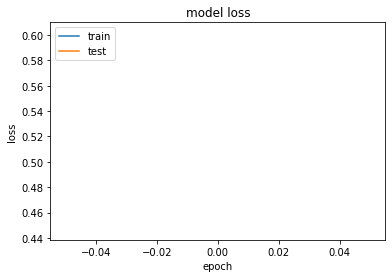

In [ ]:
import matplotlib.pyplot as plt
np.save('my_history.npy',history5N.history)
history=np.load('my_history.npy',allow_pickle='TRUE').item()
# list all data in history
print(history.keys())
# summarize history for accuracy
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Comparison

In [ ]:
import os

print('Teacher Model 1:')
teacher1.evaluate(d_valid.shuffle(1024, 19).batch(BATCH_SIZE))
print("File Size is :", round(os.path.getsize('Cifar10/teacher1.h5')/1024**2, 2), "MB")

print('Teacher Model 2:')
teacher2.evaluate(d_valid.shuffle(1024, 19).batch(BATCH_SIZE))
print("File Size is :", round(os.path.getsize('Cifar10/teacher2.h5')/1024**2, 2), "MB")

print('Teacher Model 3:')
teacher3.evaluate(d_valid.shuffle(1024, 19).batch(BATCH_SIZE))
print("File Size is :", round(os.path.getsize('Cifar10/teacher3.h5')/1024**2, 2), "MB")

print('Teacher Model 4:')
teacher4.evaluate(d_valid.shuffle(1024, 19).batch(BATCH_SIZE))
print("File Size is :", round(os.path.getsize('Cifar10/teacher4.h5')/1024**2, 2), "MB")

print('Teacher Model 5:')
teacher5.evaluate(d_valid.shuffle(1024, 19).batch(BATCH_SIZE))
print("File Size is :", round(os.path.getsize('Cifar10/teacher5.h5')/1024**2, 2), "MB")

if(distiller_Comp):
  print('Distilled Model:')
  student_model.save('student.h5')
  student_model.evaluate(d_valid.shuffle(1024, 19).batch(BATCH_SIZE))
  print("File Size is :", round(os.path.getsize('student.h5')/1024**2, 2), "MB")

if(distiller2_Comp):
  print('Distilled Model 2:')
  student2_model.save('student2.h5')
  student2_model.evaluate(d_valid.shuffle(1024, 19).batch(BATCH_SIZE))
  print("File Size is :", round(os.path.getsize('student2.h5')/1024**2, 2), "MB")


print('Distilled Model 5:')
student5_model.save('student5.h5')
student5_model.evaluate(d_valid.shuffle(1024, 19).batch(BATCH_SIZE))
print("File Size is :", round(os.path.getsize('student5.h5')/1024**2, 2), "MB")

if(True):
  print('Distilled Model 5R:')
  student5R_model.save('student5R.h5')
  student5R_model.evaluate(d_valid.shuffle(1024, 19).batch(BATCH_SIZE))
  print("File Size is :", round(os.path.getsize('student5R.h5')/1024**2, 2), "MB")

Teacher Model 1:
20/20 [==============================] - 2s 76ms/step - loss: 0.5752 - accuracy: 0.8141
File Size is : 229.35 MB
Teacher Model 2:
20/20 [==============================] - 2s 74ms/step - loss: 0.5731 - accuracy: 0.8131
File Size is : 229.35 MB
Teacher Model 3:
20/20 [==============================] - 2s 74ms/step - loss: 0.5718 - accuracy: 0.8116
File Size is : 229.35 MB
Teacher Model 4:
20/20 [==============================] - 2s 75ms/step - loss: 0.5696 - accuracy: 0.8108
File Size is : 229.35 MB
Teacher Model 5:
20/20 [==============================] - 2s 75ms/step - loss: 0.5734 - accuracy: 0.8117
File Size is : 229.35 MB
Distilled Model:
20/20 [==============================] - 1s 41ms/step - loss: 0.7739 - accuracy: 0.7379
File Size is : 6.09 MB
Distilled Model 2:
20/20 [==============================] - 1s 41ms/step - loss: 0.8911 - accuracy: 0.7268
File Size is : 6.09 MB
Distilled Model 5:
20/20 [==============================] - 1s 41ms/step - loss: 0.8239 - ac

**Reference**

* [Distilling the Knowledge in a Neural Network](https://arxiv.org/abs/1503.02531)
* [Implementation of classical Knowledge Distillation](https://keras.io/examples/vision/knowledge_distillation/)

dict_keys(['accuracy', 'student_loss', 'distillation_loss', 'loss', 'val_accuracy', 'val_student_loss', 'val_distillation_loss', 'val_loss', 'lr'])


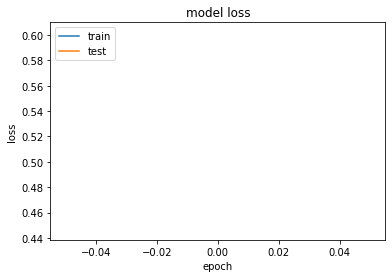

In [ ]:
import matplotlib.pyplot as plt
np.save('my_history.npy',history5N.history)
history=np.load('my_history.npy',allow_pickle='TRUE').item()
# list all data in history
print(history.keys())
# summarize history for accuracy
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

dict_keys(['accuracy', 'student_loss', 'distillation_loss', 'loss', 'val_accuracy', 'val_student_loss', 'val_distillation_loss', 'val_loss', 'lr'])


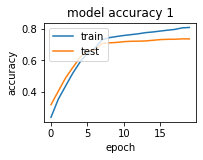

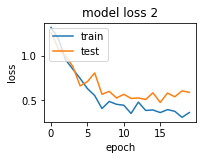

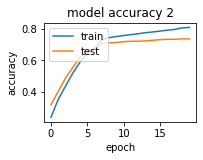

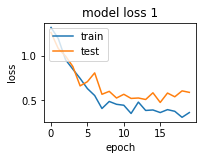

In [ ]:
import matplotlib.pyplot as plt
history=np.load('history1.npy',allow_pickle='TRUE').item()
history2=np.load('history1.npy',allow_pickle='TRUE').item()
# list all data in history
print(history.keys())
# summarize history for accuracy

ax =plt.subplot(2,2,1)
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy 1')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
ax =plt.subplot(2,2,2)
plt.plot(history2['loss'])
plt.plot(history2['val_loss'])
plt.title('model loss 2')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
ax =plt.subplot(2,2,3)
plt.plot(history2['accuracy'])
plt.plot(history2['val_accuracy'])
plt.title('model accuracy 2')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
ax =plt.subplot(2,2,4)
plt.plot(history2['loss'])
plt.plot(history2['val_loss'])
plt.title('model loss 1')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()